In [1]:
from utils import *

import lsqfit
import gvar as gv

import os
import platform
import h5py
import numpy as np
import matplotlib.pyplot as plt

userDir=os.path.expanduser('~')
baseDir=os.path.join(userDir,'Documents','LatticeQCD','PIPI')

beta=4.03

ncStep=5
NT=64

mh=0.2
ml=0.1

In [2]:
def get_avg_pion_corr_folded(sourceTimes):
    pionCorrs=get_all_pion_source_corrs(pionDir, sourceTimes, ncStart, ncFinish, ncStep)

    avgPionCorr=pionCorrs[sourceTimes[0]]
    for t0 in sourceTimes[1:]:
        avgPionCorr+=pionCorrs[t0]
    avgPionCorr=avgPionCorr/len(sourceTimes)

    avgPionCorr=np.array([foldCorr(c,NT) for c in avgPionCorr])

    return avgPionCorr

In [3]:
mlDir=os.path.join(baseDir,'b{}_ml{}_mh{}'.format(beta,ml,mh))
pionDir=os.path.join(mlDir,'mesons')

ncStart, ncFinish = get_nc_start_fin(pionDir)
NCFG = (ncFinish-ncStart)/ncStep

sourceTimes=[i for i in range(0,64,8)]
avgPionCorr=get_avg_pion_corr_folded(sourceTimes)

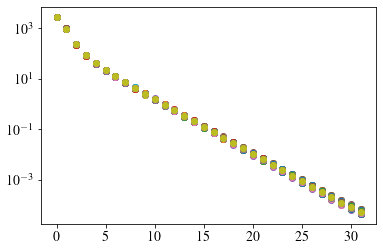

In [4]:
plt.yscale('log')
for corr in avgPionCorr:
    plt.plot(np.real(corr),linestyle="",marker="o")
plt.show()

In [5]:
np.shape(avgPionCorr)

(399, 32)

In [6]:
from jk import *
from utils import *

effMass=jackKnife(log_effective_mass,avgPionCorr)

/home/chrisculver/Code/LatticeQCD/SU4_PiPi_Analysis/utils.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  res.append(math.log(avg[t]/avg[t+1]))


(0.49, 0.505)

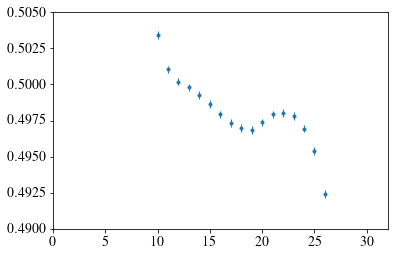

In [7]:
import matplotlib.pyplot as plt 

plt.errorbar([t for t in range(len(effMass[0]))], effMass[0].real, yerr=effMass[1].real,
    linestyle="None", marker=".", lw=1)
plt.xlim(0,32)
plt.ylim(0.49,0.505)

In [22]:
import lsqfit
from model_avg_paper import *
from model_avg_paper.test_tmin import test_vary_tmin_SE
from model_avg_paper.stats import model_avg
import gvar as gv

In [23]:
data = {'t': np.asarray([t for t in range(int(NT/2))]), 'ND': NCFG, 'yraw': np.real(avgPionCorr[:,0:int(NT/2)])}
data['y']=gv.dataset.avg_data(data['yraw'], bstrap=True)

In [24]:
def multi_exp_model(t, p, Nexc=2):
    ans = 0.0
    for i in range(0, Nexc):
        ans += p["A{}".format(i)] * np.exp(-p["E{}".format(i)] * t)
    return ans

In [25]:
fitModelSingleExp = lambda t,p : multi_exp_model(t,p,1)
paramInitSingleExp = {
    "A0": 1, "E0": 0.5,
    #"A1": 0.1, "E1": 1.5,
    #"A2": 0.0001, "E2": 0.1
}

fitModelTripleExp = lambda t,p : multi_exp_model(t,p,3)
paramInitTripleExp = {
    "A0": 1, "E0": 0.5,
    "A1": 0.1, "E1": 1.5,
    "A2": 0.0001, "E2": 0.1
}

In [26]:
minChi2=1e10
allFits={}
for ti in range(7,19):
    for tf in range(20,26):
        if tf-ti > 2:
            fitres=lsqfit.nonlinear_fit(
                data=(data['t'][ti:tf], data['y'][ti:tf]),
                fcn = fitModelSingleExp, 
                p0=paramInitSingleExp
            )
            allFits["{},{}".format(ti,tf)]=fitres

In [28]:
obsVStmin=[]
probVStmin=[]
fitICvstmin=[]
for fitTimes, fit in allFits.items():
    obsVStmin.append(fit.p["E0"])
    fitIC, prob = get_raw_model_prob(
        fit, return_IC=True, IC="AIC", ND=data["ND"], N_cut=(NT/2-tf)+ti, yraw=data["yraw"]
    )
    probVStmin.append(prob)
    fitICvstmin.append(fitIC)


In [32]:
mavg=model_avg(obsVStmin,probVStmin)
mavg

0.4985(45)

In [30]:
fitsE0=[]
fitsE0err=[]
fitRanges=[]
for fitTimes, fit in allFits.items():
    fitsE0.append(fit.p["E0"].mean)
    fitsE0err.append(fit.p["E0"].sdev)
    fitRanges.append(fitTimes)


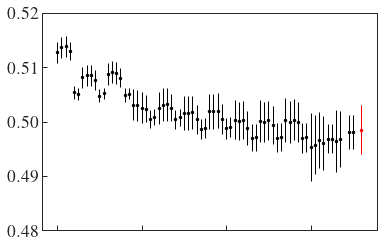

In [35]:
plt.errorbar([i for i in range(len(fitRanges))], fitsE0, yerr=fitsE0err,
    linestyle="None", marker=".", lw=1, color='black')
plt.errorbar([len(fitRanges)+1], [mavg.mean], yerr=[mavg.sdev],
    linestyle="None", marker=".", lw=1, color='red')

plt.ylim(0.48,0.52)
plt.tick_params(
    axis='x',
    labelbottom=False,
)


In [61]:
import gvar

npmean = lambda data : np.mean(data,axis=0)
jkdata=jackKnife(npmean, avgPionCorr)

data = {'t': np.asarray([t for t in range(int(NT/2))]), 'ND': NCFG, 'yraw': np.real(avgPionCorr[:,0:int(NT/2)])}
data['y']=gv.dataset.avg_data(data['yraw'], bstrap=True)
data['yNoBS']=gv.dataset.avg_data(data['yraw'])

data['yJackRaw'] = np.real(jkdata)
data['yjack']=gv.dataset.avg_data(data['yJackRaw'], bstrap=True)

In [76]:
data_iter = gv.dataset.bootstrap_iter(np.real(avgPionCorr),n=10)
data['yBS10']=gv.dataset.avg_data(np.mean([d for d in data_iter],axis=0), bstrap=True)
data_iter = gv.dataset.bootstrap_iter(np.real(avgPionCorr),n=50)
data['yBS50']=gv.dataset.avg_data(np.mean([d for d in data_iter],axis=0), bstrap=True)

In [77]:
data['yBS10']

array([2878.5(1.9), 990.5(1.3), 234.57(66), 86.96(35), 41.25(22),
       22.02(14), 12.442(85), 7.246(57), 4.293(35), 2.569(22), 1.547(14),
       0.9356(87), 0.5671(53), 0.3439(34), 0.2086(22), 0.1266(14),
       0.07686(95), 0.04670(63), 0.02839(42), 0.01727(27), 0.01051(18),
       0.00639(12), 0.003883(77), 0.002360(50), 0.001434(32),
       0.000872(20), 0.000532(13), 0.0003249(81), 0.0002001(52),
       0.0001255(35), 0.0000826(24), 0.0000537(17)], dtype=object)

In [62]:
data['yjack']

array([1439(982), 495(338), 117(80), 44(30), 21(14), 11.0(7.5), 6.2(4.2),
       3.6(2.5), 2.2(1.5), 1.29(88), 0.78(53), 0.47(32), 0.28(19),
       0.17(12), 0.104(71), 0.063(43), 0.039(26), 0.023(16), 0.0142(97),
       0.0087(59), 0.0053(36), 0.0032(22), 0.0019(13), 0.00119(80),
       0.00072(49), 0.00044(30), 0.00027(18), 0.00016(11), 0.000101(68),
       0.000063(43), 0.000042(28), 0.000027(18)], dtype=object)

In [78]:
efmTest=gvar.log([data['y'][t]/data['y'][t+1] for t in range(len(data['y'])-1)])
efmNoBS=gvar.log([data['yNoBS'][t]/data['yNoBS'][t+1] for t in range(len(data['y'])-1)])
efmJK=gvar.log([data['yjack'][t]/data['yjack'][t+1] for t in range(len(data['y'])-1)])
efmBS10=gvar.log([data['yBS10'][t]/data['yBS10'][t+1] for t in range(len(data['yBS10'])-1)])
efmBS50=gvar.log([data['yBS50'][t]/data['yBS50'][t+1] for t in range(len(data['yBS50'])-1)])


(0.47, 0.52)

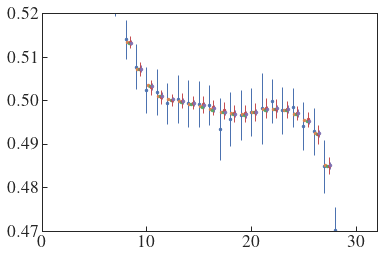

In [80]:
plt.errorbar([t for t in range(len(efmTest))],[e.mean for e in efmTest],yerr=[e.sdev for e in efmTest],
            linestyle="None", marker=".", lw=1)
plt.errorbar([t+0.1 for t in range(len(efmNoBS))],[e.mean for e in efmNoBS],yerr=[e.sdev for e in efmNoBS],
            linestyle="None", marker=".", lw=1)
plt.errorbar([t+0.3 for t in range(len(efmJK))],[e.mean for e in efmJK],yerr=[e.sdev for e in efmJK],
            linestyle="None", marker=".", lw=1)
plt.errorbar([t+0.4 for t in range(len(efmBS10))],[e.mean for e in efmBS10],yerr=[e.sdev for e in efmBS10],
            linestyle="None", marker=".", lw=1)
plt.errorbar([t+0.5 for t in range(len(efmBS50))],[e.mean for e in efmBS50],yerr=[e.sdev for e in efmBS50],
            linestyle="None", marker=".", lw=1)
plt.xlim(0,32)
plt.ylim(0.47,0.52)

(0.49, 0.505)

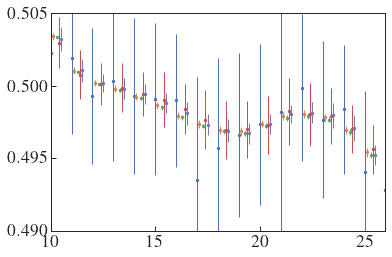

In [82]:
plt.errorbar([t for t in range(len(efmTest))],[e.mean for e in efmTest],yerr=[e.sdev for e in efmTest],
            linestyle="None", marker=".", lw=1)
plt.errorbar([t+0.1 for t in range(len(efmNoBS))],[e.mean for e in efmNoBS],yerr=[e.sdev for e in efmNoBS],
            linestyle="None", marker=".", lw=1)
plt.errorbar([t+0.3 for t in range(len(efmJK))],[e.mean for e in efmJK],yerr=[e.sdev for e in efmJK],
            linestyle="None", marker=".", lw=1)
plt.errorbar([t+0.4 for t in range(len(efmBS10))],[e.mean for e in efmBS10],yerr=[e.sdev for e in efmBS10],
            linestyle="None", marker=".", lw=1)
plt.errorbar([t+0.5 for t in range(len(efmBS50))],[e.mean for e in efmBS50],yerr=[e.sdev for e in efmBS50],
            linestyle="None", marker=".", lw=1)
plt.xlim(10,26)
plt.ylim(0.49,0.505)

In [93]:
allFits={}
for ti in range(7,19):
    for tf in range(20,26):
        if tf-ti > 2:
            fitres=lsqfit.nonlinear_fit(
                data=(data['t'][ti:tf], data['yBS50'][ti:tf]),
                fcn = fitModelSingleExp, 
                p0=paramInitSingleExp
            )
            print(fitres.chi2)
            allFits["{},{}".format(ti,tf)]=fitres

3201.366339240737
3203.998028166268
3204.3536213664397
3335.83064545722
3416.764991982725
3420.547565372634
918.0319286220381
994.0213368956342
1058.1159038333296
1213.553921492915
1226.1202196492593
1296.0031514360053
355.48925469688754
363.76963664009855
364.49295887342237
365.25946805255916
369.6669452897383
370.54191833595115
160.9125847237278
162.78230286885682
163.21104918154808
163.61657076186125
163.6969145032406
165.6535396469323
43.18292329014859
70.07894903391411
72.91289533201778
73.307360013185
79.81215408718752
80.48165828321717
17.620202033907113
25.61160807977607
33.53831374529038
33.54591052229659
33.70026753553763
33.91866768453512
8.36950947763775
11.730937478519982
15.241507217406784
18.404347707455006
18.517484746920687
18.598152147135405
5.983397061999438
7.722529246364868
7.805893163985465
9.290103045147452
11.229291647642023
11.540286185365314
3.7425354636970245
4.72542760303927
4.811189222786366
4.817944089505854
5.567734644539397
6.817954769348964
2.3436517275

In [88]:
obsVStmin=[]
probVStmin=[]
fitICvstmin=[]
for fitTimes, fit in allFits.items():
    obsVStmin.append(fit.p["E0"])
    fitIC, prob = get_raw_model_prob(
        fit, return_IC=True, IC="AIC", ND=data["ND"], N_cut=(NT/2-tf)+ti, yraw=data["yraw"]
    )
    probVStmin.append(prob)
    fitICvstmin.append(fitIC)


In [89]:
mavg=model_avg(obsVStmin,probVStmin)
mavg

0.49731(68)

In [90]:
fitsE0=[]
fitsE0err=[]
fitRanges=[]
for fitTimes, fit in allFits.items():
    fitsE0.append(fit.p["E0"].mean)
    fitsE0err.append(fit.p["E0"].sdev)
    fitRanges.append(fitTimes)


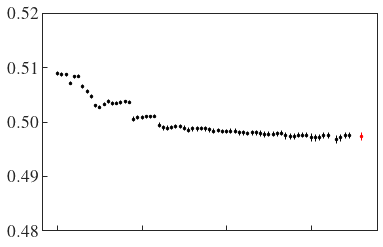

In [91]:
plt.errorbar([i for i in range(len(fitRanges))], fitsE0, yerr=fitsE0err,
    linestyle="None", marker=".", lw=1, color='black')
plt.errorbar([len(fitRanges)+1], [mavg.mean], yerr=[mavg.sdev],
    linestyle="None", marker=".", lw=1, color='red')

plt.ylim(0.48,0.52)
plt.tick_params(
    axis='x',
    labelbottom=False,
)
